In [1]:
import ee
ee.Authenticate(auth_mode='notebook')
ee.Initialize(project='global-booster-421311')


In [2]:
catchments = ee.FeatureCollection('projects/global-booster-421311/assets/LakeCatchments_NA')

variables_mean = [
    'temperature_2m',
    'lake_mix_layer_temperature'
]
variables_sum = [
    'total_precipitation_sum',
    'surface_runoff_sum',
    'runoff_sum'
]
export_fields = [
    'Lake_ID', 'year', 'week', 'week_start', 'week_end',
    'temperature_2m',
    'lake_mix_layer_temperature',
    'total_precipitation_sum',
    'surface_runoff_sum',
    'runoff_sum'
]

def features_for_week(era, year, week):
    week = ee.Number(week)
    start_day = week.subtract(1).multiply(7)
    end_day = week.multiply(7).subtract(1)
    start_date = ee.Date(f'{year}-01-01').advance(start_day, 'day')
    end_date = ee.Date(f'{year}-01-01').advance(end_day, 'day')
    week_imgs = era.filterDate(start_date, end_date.advance(1, 'day'))
    mean_img = week_imgs.mean().select(variables_mean)
    sum_img = week_imgs.sum().select(variables_sum)
    stack = mean_img.addBands(sum_img)
    stats = stack.reduceRegions(
        collection=catchments,
        reducer=ee.Reducer.mean().forEachBand(mean_img)
                .combine(ee.Reducer.sum().forEachBand(sum_img), '', False),
        scale=10000
    ).map(lambda f: f.set({
        'year': year,
        'week': week,
        'week_start': start_date.format('YYYY/MM/dd'),
        'week_end': end_date.format('YYYY/MM/dd')
    }))
    return stats

def drop_geometry(feature):
    return feature.setGeometry(None)

years = list(range(2002, 2023))  # 2002 to 2022

for year in years:
    print(f"Processing year {year}...")
    era = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(f'{year}-01-01', f'{year+1}-01-01')
    weeks = list(range(1, 54))
    weekly_collections = ee.List(weeks).map(lambda w: features_for_week(era, year, ee.Number(w)))
    all_features = ee.FeatureCollection(weekly_collections).flatten()
    all_features_no_geom = all_features.map(drop_geometry)
    task = ee.batch.Export.table.toDrive(
        collection=all_features_no_geom.select(export_fields),
        description=f'ERA5Land_Weekly_Catchments_{year}_Climate',
        fileFormat='CSV'
    )
    task.start()
    print(f"Export started for {year}! Monitor in GEE Tasks.")

print("All yearly exports started! 🚀")


Processing year 2002...
Export started for 2002! Monitor in GEE Tasks.
Processing year 2003...
Export started for 2003! Monitor in GEE Tasks.
Processing year 2004...
Export started for 2004! Monitor in GEE Tasks.
Processing year 2005...
Export started for 2005! Monitor in GEE Tasks.
Processing year 2006...
Export started for 2006! Monitor in GEE Tasks.
Processing year 2007...
Export started for 2007! Monitor in GEE Tasks.
Processing year 2008...
Export started for 2008! Monitor in GEE Tasks.
Processing year 2009...
Export started for 2009! Monitor in GEE Tasks.
Processing year 2010...
Export started for 2010! Monitor in GEE Tasks.
Processing year 2011...
Export started for 2011! Monitor in GEE Tasks.
Processing year 2012...
Export started for 2012! Monitor in GEE Tasks.
Processing year 2013...
Export started for 2013! Monitor in GEE Tasks.
Processing year 2014...
Export started for 2014! Monitor in GEE Tasks.
Processing year 2015...
Export started for 2015! Monitor in GEE Tasks.
Proces

In [3]:
import pandas as pd
import os

folder = "Datasets\ECMWF_raw"  # adjust if needed

for fname in os.listdir(folder):
    if fname.startswith('ERA5Land_Weekly_Catchments_') and fname.endswith('.csv'):
        fpath = os.path.join(folder, fname)
        df = pd.read_csv(fpath)

        # Drop unwanted columns if present
        to_drop = ['.geo', 'system:index']
        df = df.drop(columns=[col for col in to_drop if col in df.columns])

        # Desired column order
        main_cols = ['Lake_ID', 'year', 'week', 'week_start', 'week_end']
        other_cols = [col for col in df.columns if col not in main_cols]
        df = df[main_cols + other_cols]

        # Sort by Lake_ID and date (year, week)
        df = df.sort_values(by=['Lake_ID', 'year', 'week'])

        # Save cleaned table (overwrite or add suffix if you prefer)
        df.to_csv(fpath, index=False)
        print(f"✅ Cleaned and exported: {fname}")

print("🎉 All ERA5 weekly climate CSVs cleaned and sorted!")


<>:4: SyntaxWarning: invalid escape sequence '\E'
<>:4: SyntaxWarning: invalid escape sequence '\E'
C:\Users\Admin\AppData\Local\Temp\ipykernel_8452\837366890.py:4: SyntaxWarning: invalid escape sequence '\E'
  folder = "Datasets\ECMWF_raw"  # adjust if needed


✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2002_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2003_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2004_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2005_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2006_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2007_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2008_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2009_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2010_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2011_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2012_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2013_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2014_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchments_2015_Climate.csv
✅ Cleaned and exported: ERA5Land_Weekly_Catchmen

<>:6: SyntaxWarning: invalid escape sequence '\I'
<>:6: SyntaxWarning: invalid escape sequence '\I'
C:\Users\Admin\AppData\Local\Temp\ipykernel_7124\2913555771.py:6: SyntaxWarning: invalid escape sequence '\I'
  df = pd.read_csv('Datasets\Interpolated_Lake_CSVs\Lake_27.csv')


Correlation with chla_mean:
lake_mix_layer_temperature_C   -0.275356
runoff_sum                     -0.035508
surface_runoff_sum              0.227647
temperature_2m_C               -0.133305
total_precipitation_sum        -0.162869
Name: chla_mean, dtype: float64


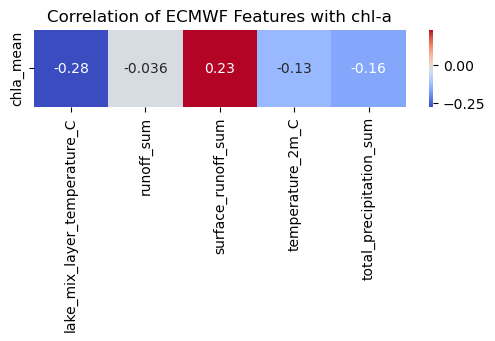

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('Datasets\Interpolated_Lake_CSVs\Lake_27.csv')

# Optionally, convert temperature columns from Kelvin to Celsius
for col in ['lake_mix_layer_temperature', 'temperature_2m']:
    if col in df.columns:
        df[col + '_C'] = df[col] - 273.15

# List of ECMWF features to check correlation with chla_mean
ecmwf_cols = [
    'lake_mix_layer_temperature_C',  # use Celsius version for clarity
    'runoff_sum',
    'surface_runoff_sum',
    'temperature_2m_C',
    'total_precipitation_sum'
]
ecmwf_cols = [col for col in ecmwf_cols if col in df.columns]  # filter only present

# Compute correlation with chla_mean
corrs = df[ecmwf_cols + ['chla_mean']].corr()['chla_mean'].drop('chla_mean')

print("Correlation with chla_mean:")
print(corrs)

# Optionally: visualize as heatmap
plt.figure(figsize=(6, 1))
sns.heatmap(corrs.to_frame().T, annot=True, cmap='coolwarm')
plt.title('Correlation of ECMWF Features with chl-a')
plt.show()


<>:6: SyntaxWarning: invalid escape sequence '\I'
<>:6: SyntaxWarning: invalid escape sequence '\I'
C:\Users\Admin\AppData\Local\Temp\ipykernel_7124\4244817528.py:6: SyntaxWarning: invalid escape sequence '\I'
  df = pd.read_csv('Datasets\Interpolated_Lake_CSVs\Lake_27.csv')


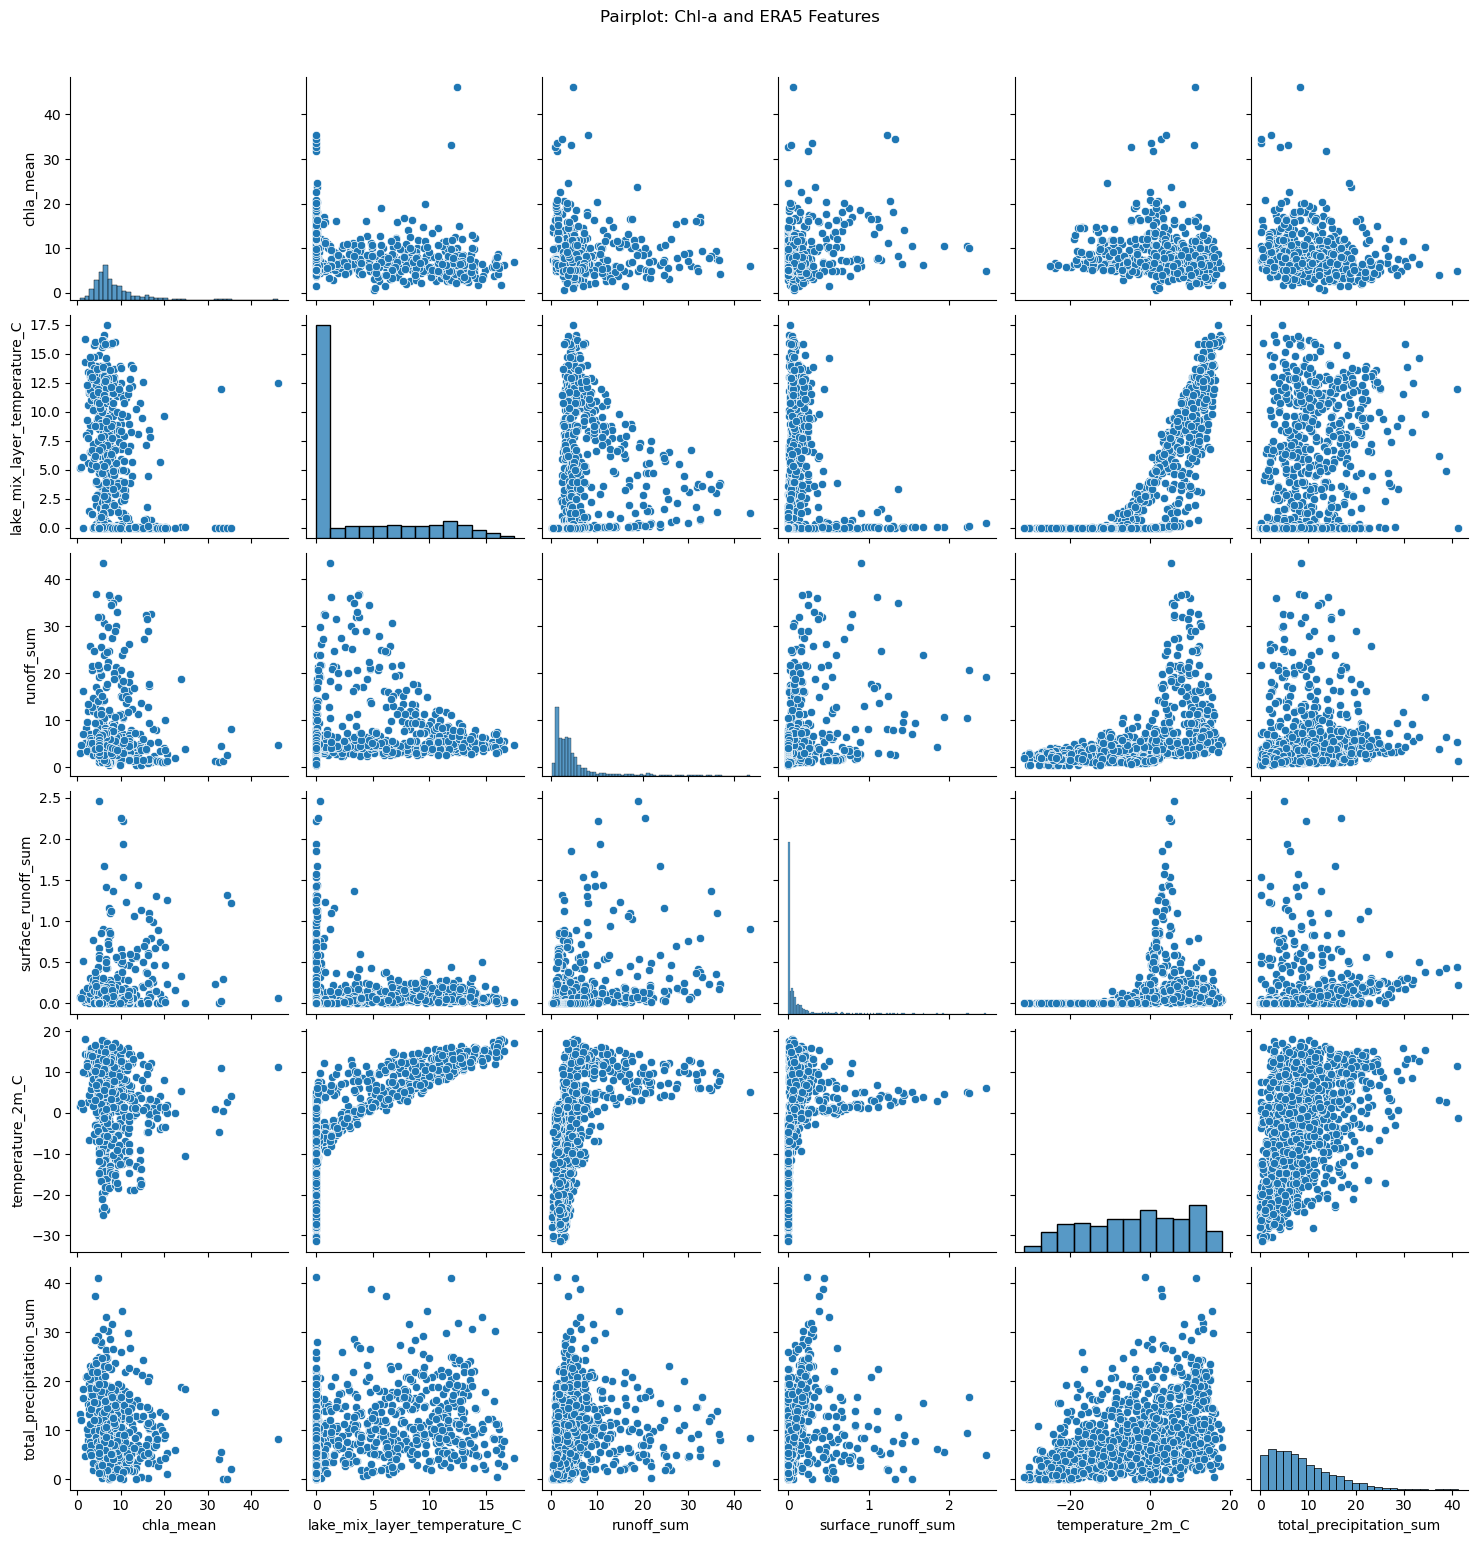

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('Datasets\Interpolated_Lake_CSVs\Lake_27.csv')

# Convert temperature columns to Celsius (optional but clearer)
for col in ['lake_mix_layer_temperature', 'temperature_2m']:
    if col in df.columns:
        df[col + '_C'] = df[col] - 273.15

# Columns to include in the pairplot
pairplot_cols = [
    'chla_mean',
    'lake_mix_layer_temperature_C',
    'runoff_sum',
    'surface_runoff_sum',
    'temperature_2m_C',
    'total_precipitation_sum'
]
pairplot_cols = [col for col in pairplot_cols if col in df.columns]  # Only keep present columns

# Make the pairplot
sns.pairplot(df[pairplot_cols], diag_kind='hist')
plt.suptitle("Pairplot: Chl-a and ERA5 Features", y=1.03)
plt.show()


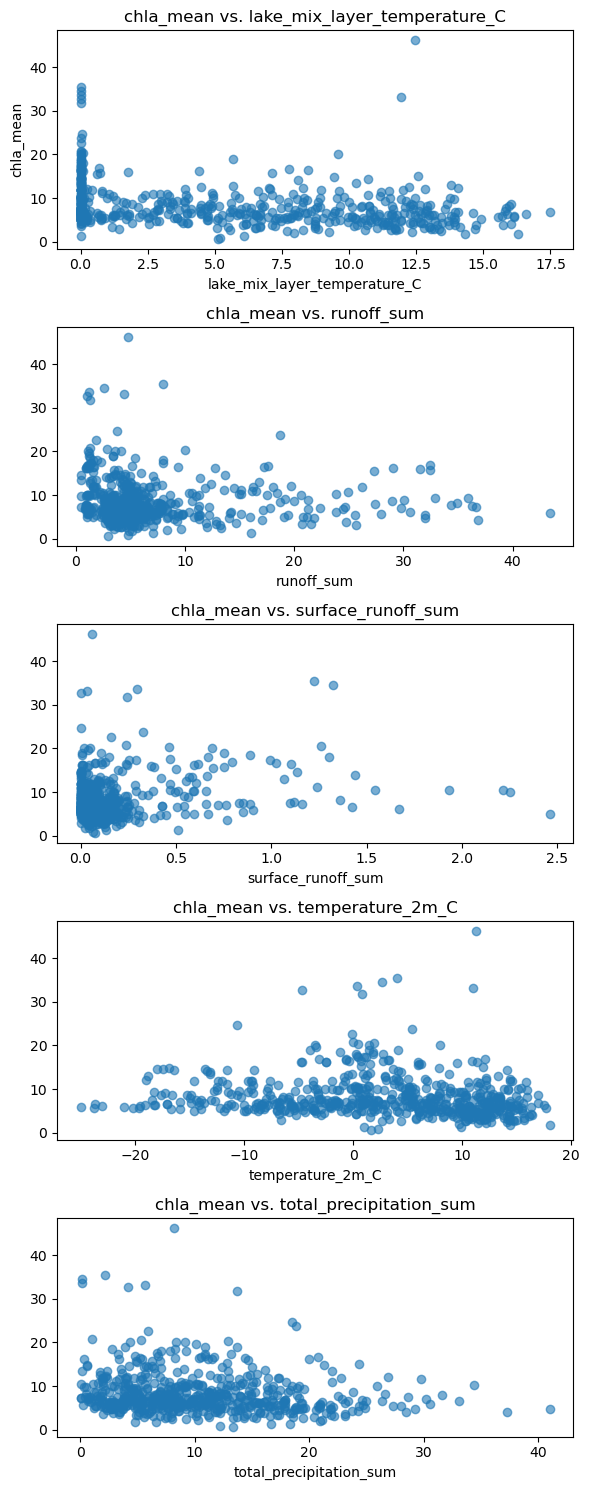

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('Datasets/Interpolated_Lake_CSVs/Lake_27.csv')

# Convert temperature columns to Celsius (optional but clearer)
for col in ['lake_mix_layer_temperature', 'temperature_2m']:
    if col in df.columns:
        df[col + '_C'] = df[col] - 273.15

# Features to compare with chla_mean
features = [
    'lake_mix_layer_temperature_C',
    'runoff_sum',
    'surface_runoff_sum',
    'temperature_2m_C',
    'total_precipitation_sum'
]
features = [col for col in features if col in df.columns]  # Only keep present columns

# Plot: Each feature vs. chla_mean
n = len(features)
fig, axes = plt.subplots(n, 1, figsize=(6, 3 * n), sharey=True)
for i, feat in enumerate(features):
    ax = axes[i]
    ax.scatter(df[feat], df['chla_mean'], alpha=0.6)
    ax.set_xlabel(feat)
    if i == 0:
        ax.set_ylabel('chla_mean')
    else:
        ax.set_ylabel('')
    ax.set_title(f'chla_mean vs. {feat}')
plt.tight_layout()
plt.show()



In [9]:
import pandas as pd

df = pd.read_csv('Datasets/Interpolated_Lake_CSVs/Lake_63.csv')

# Convert temperatures to Celsius
for col in ['lake_mix_layer_temperature', 'temperature_2m']:
    if col in df.columns:
        df[col + '_C'] = df[col] - 273.15

features = [
    'lake_mix_layer_temperature_C',
    'runoff_sum',
    'surface_runoff_sum',
    'temperature_2m_C',
    'total_precipitation_sum'
]
features = [col for col in features if col in df.columns]

# Compute contemporaneous (no-lag) correlations
corr_no_lag = df[['chla_mean'] + features].corr()['chla_mean'].drop('chla_mean')
print("Contemporaneous (no-lag) correlations:")
print(corr_no_lag)



Contemporaneous (no-lag) correlations:
lake_mix_layer_temperature_C   -0.394327
runoff_sum                     -0.200543
surface_runoff_sum              0.166438
temperature_2m_C               -0.261065
total_precipitation_sum        -0.188757
Name: chla_mean, dtype: float64


In [11]:
max_lag = 4  # You can increase this

best_lags = {}
best_lag_corrs = {}

for feat in features:
    best_corr = 0
    best_lag = 0
    for lag in range(1, max_lag + 1):
        corr = df['chla_mean'].corr(df[feat].shift(lag))
        if pd.notnull(corr) and abs(corr) > abs(best_corr):
            best_corr = corr
            best_lag = lag
    best_lags[feat] = best_lag
    best_lag_corrs[feat] = best_corr

print("\nBest lag and correlation for each feature (absolute max correlation):")
for feat in features:
    print(f"{feat}: best lag = {best_lags[feat]}, corr = {best_lag_corrs[feat]:.3f}")



Best lag and correlation for each feature (absolute max correlation):
lake_mix_layer_temperature_C: best lag = 1, corr = -0.380
runoff_sum: best lag = 3, corr = -0.349
surface_runoff_sum: best lag = 4, corr = -0.116
temperature_2m_C: best lag = 4, corr = -0.425
total_precipitation_sum: best lag = 3, corr = -0.227


In [12]:
summary = pd.DataFrame({
    'NoLag_corr': corr_no_lag,
    'BestLag': pd.Series(best_lags),
    'BestLag_corr': pd.Series(best_lag_corrs)
})

print("\nComparison table (feature, no-lag corr, best lag, best lag corr):")
print(summary)



Comparison table (feature, no-lag corr, best lag, best lag corr):
                              NoLag_corr  BestLag  BestLag_corr
lake_mix_layer_temperature_C   -0.394327        1     -0.379552
runoff_sum                     -0.200543        3     -0.349068
surface_runoff_sum              0.166438        4     -0.115800
temperature_2m_C               -0.261065        4     -0.424862
total_precipitation_sum        -0.188757        3     -0.226990
